In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/original_data.csv")

---------------

# Untrusted Bars/Pubs

In this notebook we wish to filter out untrusted bars, meaning their `guest_count` feature is not reasonable (cannot be trusted).  
`guest_count` values of 0 or 1 usually sounds suspicious.

Later on, we'll be using these bars only for our (occasion) prediction task.  
If after cleaning, we'll be left with too few trusted bars, we'd consider using some **less** trusted bars.  
Also, if time permits, we'll consider using a heuristic function for calculating the `guest_count`, allowing us to use all, or most of, the untrusted bars.

Our measure for charging a bar as untrusted:
1. Its `guest_count`'s maximum value is 0 or 1.
2. Its `guest_count`'s std equals 0.
3. Its `guest_count`'s median equals 0.

Something to think about:
3. Its `guest_count`'s median equals 1.
4. Its `guest_count`'s std and median are not reasonable.
5. Its `guest_count` & `total_sales_before_tax` do not correlate.
6. Its `guest_count` & `total_orders` do not correlate.

-------------

In [3]:
df['total_sales_before_tax'] = df.groupby('order_id')['sales_before_tax'].transform('sum')
df['total_sales_inc_tax'] = df.groupby('order_id')['sales_inc_tax'].transform('sum')

In [4]:
df['total_orders'] = df.groupby('order_id')['order_id'].transform('size')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754466 entries, 0 to 1754465
Data columns (total 29 columns):
city                           object
bar_id                         int64
order_id                       int64
order_time                     object
order_item_id                  int64
title                          object
category_id                    float64
beer_brand_id                  int64
beer_serving_type_id           int64
beer_volume                    float64
item_qty                       float64
sales_before_tax               float64
sales_inc_tax                  float64
guest_count                    int64
waiter_id                      float64
country                        object
country_id                     int64
state                          object
state_id                       int64
timezone                       object
bar_type_id                    int64
status                         int64
last_status                    int64
is_bulk           

Keep relevant features only for bars filtration:

In [6]:
columns = ['bar_id', 'order_id', 'order_time', 'order_item_id', 'title', 'category_id',
           'beer_volume', 'item_qty', 'guest_count', 'sales_before_tax', 'total_sales_before_tax', 'total_orders']
df = df[columns]

In [7]:
df.head()

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
0,2182,649875004,2019-07-18 09:12:44.000,64987500402,BACON,2.0,0.0,1.0,1,0.00,6.5,4
1,2182,649875004,2019-07-18 09:12:44.000,64987500403,PAIN BLANC,2.0,0.0,1.0,1,0.00,6.5,4
2,2182,649875004,2019-07-18 09:12:44.000,64987500400,GRASSE MATINEE,5.0,0.0,1.0,1,6.50,6.5,4
3,2182,649875004,2019-07-18 09:12:44.000,64987500401,BROUILLÉ,2.0,0.0,1.0,1,0.00,6.5,4
4,3383,649932765,2019-07-18 12:19:29.000,64993276502,Pickeral & Chips,2.0,0.0,1.0,2,17.99,35.9,3


-------------

Start by creating the relevant dataframes:
- tables dataframes (entry per `order_id`)
- bars dataframe (entry per `bar_id`)

In [8]:
bars = df.bar_id.unique()
print("There are " + str(len(bars)) + " bars in Canada.")

There are 425 bars in Canada.


It's enough working by table (`order_id`) rather than items (`order_item_id`), let's shrink the data and keep relevant features only:

In [9]:
features = ['bar_id', 'guest_count']

In [10]:
tables = df.drop_duplicates(subset='order_id', keep='first')
tables.set_index('order_id', inplace=True)
tables = tables[features]
tables.head()

,bar_id,guest_count
order_id,,
649875004,2182,1
649932765,3383,2
649943518,5130,0
649944658,3383,2
650184356,2182,2


In [11]:
print("There are " + str(len(tables)) + " tables.")

There are 391729 tables.


In [12]:
tables.guest_count.value_counts().sort_index()

-1            3
 0       109512
 1       161947
 2        70895
 3        21581
 4        13394
 5         5281
 6         3250
 7         1583
 8         1275
 9          790
 10         617
 11         355
 12         249
 13         165
 14         127
 15         118
 16          93
 17          71
 18          67
 19          40
 20          62
 21          19
 22          35
 23          18
 24          24
 25          35
 26          11
 27          10
 28           7
          ...  
 49           1
 50           1
 51           2
 52           1
 53           1
 55           1
 56           1
 57           1
 58           1
 61           2
 62           2
 63           1
 65           1
 66           2
 72           3
 74           5
 87           2
 91           1
 93           1
 99           5
 100          1
 101          1
 134          1
 144          1
 203          1
 210          1
 222          2
 851          1
 999          1
 2670         1
Name: guest_count, Lengt

Let's look at the distribution for each bar's `guest_count`:

In [13]:
tables.groupby('bar_id').guest_count.value_counts(normalize=True)

bar_id  guest_count
426     1              0.855731
        2              0.110672
        3              0.019763
        4              0.009881
        5              0.003953
427     1              0.788315
        2              0.153260
        3              0.039797
        4              0.010161
        7              0.002540
        8              0.001693
        5              0.000847
        6              0.000847
        9              0.000847
        10             0.000847
        12             0.000847
430     1              0.860204
        2              0.111224
        3              0.017347
        4              0.004082
        6              0.002041
        7              0.002041
        8              0.002041
        5              0.001020
431     1              0.824803
        2              0.143701
        3              0.021654
        4              0.005906
        5              0.003937
432     1              0.692364
                    

Extract the description for the `guest_count` feature:
- mean, std
- min, max
- quartiles (25%, 50% - median, 75%)

In [14]:
tables.groupby('bar_id').guest_count.describe().head()

,count,mean,std,min,25%,50%,75%,max
bar_id,,,,,,,,
426,506.0,1.195652,0.551560,1.0,1.0,1.0,1.0,5.0
427,1181.0,1.321761,0.857534,1.0,1.0,1.0,1.0,12.0
430,980.0,1.198980,0.647300,1.0,1.0,1.0,1.0,8.0
431,508.0,1.220472,0.546293,1.0,1.0,1.0,1.0,5.0
432,1375.0,1.546909,1.103364,1.0,1.0,1.0,2.0,10.0


In [15]:
desc = tables.groupby('bar_id').guest_count.describe()
desc_columns = ['guest_count_count', 'guest_count_mean', 'guest_count_std', 'guest_count_min', \
                'guest_count_25%', 'guest_count_50%', 'guest_count_75%', 'guest_count_max']
desc.columns = desc_columns

In [16]:
desc.head()

,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
bar_id,,,,,,,,
426,506.0,1.195652,0.551560,1.0,1.0,1.0,1.0,5.0
427,1181.0,1.321761,0.857534,1.0,1.0,1.0,1.0,12.0
430,980.0,1.198980,0.647300,1.0,1.0,1.0,1.0,8.0
431,508.0,1.220472,0.546293,1.0,1.0,1.0,1.0,5.0
432,1375.0,1.546909,1.103364,1.0,1.0,1.0,2.0,10.0


In [17]:
tables = tables.reset_index().merge(desc, on='bar_id').set_index(tables.index).drop(['order_id'], axis=1)

In [18]:
tables.head()

,bar_id,guest_count,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
order_id,,,,,,,,,,
649875004,2182,1,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
649932765,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
649943518,2182,3,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
649944658,2182,1,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
650184356,2182,1,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0


In [19]:
bars_data = tables.drop_duplicates(subset='bar_id', keep='first')[['bar_id'] + desc_columns]
bars_data.set_index('bar_id', inplace=True)

In [20]:
bars_data.head()

,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
bar_id,,,,,,,,
2182,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
3383,1232.0,2.028409,1.981639,0.0,1.0,2.0,3.0,30.0
5130,956.0,1.742678,2.684588,0.0,1.0,1.0,2.0,42.0
17125,1793.0,2.799219,3.009816,0.0,1.0,2.0,3.0,52.0
1168,2213.0,1.570718,1.357483,0.0,1.0,1.0,2.0,14.0


Make sure the new dataframe (`bars_data`) is of the same size as our `bars` dataframe:

In [21]:
assert(len(bars) == len(bars_data))

### `guest_count_max`

In [22]:
len(bars_data[bars_data['guest_count_max'] == 0])

90

In [23]:
len(bars_data[bars_data['guest_count_max'] == 1])

56

Drop all bars with `guest_count_max` = 0/1, these are certainly untrusted.

In [24]:
bars_data = bars_data[(bars_data.guest_count_max != 0) & (bars_data.guest_count_max != 1)]

In [25]:
bars_data.head()

,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
bar_id,,,,,,,,
2182,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
3383,1232.0,2.028409,1.981639,0.0,1.0,2.0,3.0,30.0
5130,956.0,1.742678,2.684588,0.0,1.0,1.0,2.0,42.0
17125,1793.0,2.799219,3.009816,0.0,1.0,2.0,3.0,52.0
1168,2213.0,1.570718,1.357483,0.0,1.0,1.0,2.0,14.0


In [26]:
print("We're left with " + str(len(bars_data)) + " bars in total.")

We're left with 279 bars in total.


### mean, median, std

Let's try something more "advanced"; look at the means, medians and stds:

In [27]:
bars_data[bars_data['guest_count_mean'] > 5]

,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
bar_id,,,,,,,,
11719,573.0,6.157068,111.484922,0.0,1.0,1.0,2.0,2670.0


Odd.

In [28]:
max(list(tables[tables['bar_id'] == 11719]['guest_count']))

2670

In [29]:
tables[(tables['bar_id'] == 11719) & (tables['guest_count'] > 10)]

,bar_id,guest_count,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
order_id,,,,,,,,,,
650913011,11719,11,573.0,6.157068,111.484922,0.0,1.0,1.0,2.0,2670.0
647654172,11719,2670,573.0,6.157068,111.484922,0.0,1.0,1.0,2.0,2670.0
648305162,11719,11,573.0,6.157068,111.484922,0.0,1.0,1.0,2.0,2670.0


In [30]:
df[(df['bar_id'] == 11719) & (df['guest_count'] == 2670)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
852198,11719,649563564,2019-07-17 18:26:13.000,64956356401,Pesto Pz,2.0,0.0,1.0,2670,18.0,37.0,3
852199,11719,649563564,2019-07-17 18:26:13.000,64956356402,Teo Caesar,3.0,0.0,1.0,2670,9.0,37.0,3
852200,11719,649563564,2019-07-17 18:26:13.000,64956356400,Tom Brusch,2.0,0.0,1.0,2670,10.0,37.0,3


In [31]:
tables[tables['guest_count'] > 200]

,bar_id,guest_count,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
order_id,,,,,,,,,,
647271110,2172,210,978.0,2.278119,8.019063,0.0,1.0,2.0,2.0,210.0
650303711,1898,222,1441.0,1.483692,5.934238,0.0,1.0,1.0,2.0,222.0
651981927,2097,203,1143.0,1.265092,5.988363,1.0,1.0,1.0,1.0,203.0
649550436,10847,851,2787.0,1.809473,16.505604,0.0,1.0,1.0,1.0,851.0
647654172,11719,2670,573.0,6.157068,111.484922,0.0,1.0,1.0,2.0,2670.0
649932703,2319,999,1669.0,2.158179,24.487116,0.0,0.0,2.0,2.0,999.0
651983003,4244,222,651.0,2.937020,9.960261,0.0,1.0,2.0,3.0,222.0


In [32]:
df[(df['bar_id'] == 2172) & (df['guest_count'] == 210)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
913764,2172,651005663,2019-07-19 20:21:10.000,65100566310,B.JUS 12 oz,4.0,0.000,2.0,210,7.50,301.35,16
913765,2172,651005663,2019-07-19 20:21:10.000,65100566311,A.COTE LEVEES DEMI,2.0,0.000,1.0,210,18.00,301.35,16
913766,2172,651005663,2019-07-19 20:21:10.000,65100566313,A.CARBONARA,2.0,0.000,3.0,210,69.00,301.35,16
913767,2172,651005663,2019-07-19 20:21:10.000,65100566306,VIRE CAPOT,1.0,0.500,1.0,210,9.95,301.35,16
913768,2172,651005663,2019-07-19 20:21:10.000,65100566307,A.CASSEROLE MOULE,2.0,0.000,1.0,210,18.00,301.35,16
913769,2172,651005663,2019-07-19 20:21:10.000,65100566309,A.TARTE AU BLEUET,2.0,0.000,1.0,210,6.00,301.35,16
913770,2172,651005663,2019-07-19 20:21:10.000,65100566305,KIR,3.0,0.000,1.0,210,9.00,301.35,16
913771,2172,651005663,2019-07-19 20:21:10.000,65100566312,A.PENNE FROMAGE CHEV,2.0,0.000,1.0,210,22.00,301.35,16
913772,2172,651005663,2019-07-19 20:21:10.000,65100566314,A.RAVIOLIS CHAMP,2.0,0.000,1.0,210,25.00,301.35,16
913773,2172,651005663,2019-07-19 20:21:10.000,65100566300,B.THE GLACE,4.0,0.000,1.0,210,3.00,301.35,16


Reasonable.

In [33]:
df[(df['bar_id'] == 1898) & (df['guest_count'] == 222)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
373211,1898,649417338,2019-07-17 18:13:00.000,64941733800,6oz Jack Chardonnay,6.0,0.0,1.0,222,4.5,4.5,1


In [34]:
df[(df['bar_id'] == 2097) & (df['guest_count'] == 203)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
175126,2097,648288423,2019-07-15 20:00:11.000,64828842301,EL NACHO LIBRE,2.0,0.0,0.67,203,7.34,16.04,2
175127,2097,648288423,2019-07-15 20:00:11.000,64828842300,CERISE SAT 500ML,3.0,0.0,1.00,203,8.70,16.04,2


In [35]:
df[(df['bar_id'] == 10847) & (df['guest_count'] == 851)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
746063,10847,651966674,2019-07-20 16:50:58.000,65196667400,RED BULL,4.0,0.0,1.0,851,3.0,3.0,1


In [36]:
df[(df['bar_id'] == 2319) & (df['guest_count'] == 999)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
617718,2319,648176926,2019-07-15 15:43:44.000,64817692600,DEEP FRIED PICKLES,2.0,0.000,1.0,999,8.00,45.98,6
617719,2319,648176926,2019-07-15 15:43:44.000,64817692602,WATER,1.0,1.023,3.0,999,0.00,45.98,6
617720,2319,648176926,2019-07-15 15:43:44.000,64817692603,PB PINEAPPLE,3.0,0.000,1.0,999,5.99,45.98,6
617721,2319,648176926,2019-07-15 15:43:44.000,64817692601,PERCH ROLL,2.0,0.000,1.0,999,17.50,45.98,6
617722,2319,648176926,2019-07-15 15:43:44.000,64817692604,PB LIME CHERRY,3.0,0.000,1.0,999,5.99,45.98,6
617723,2319,648176926,2019-07-15 15:43:44.000,64817692605,BLUE 710,1.0,0.710,1.0,999,8.50,45.98,6


In [37]:
df[(df['bar_id'] == 4244) & (df['guest_count'] == 222)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
1311484,4244,649182790,2019-07-17 13:20:28.000,64918279000,NO.2 CHICKEN,2.0,0.0,1.0,222,13.0,61.0,6
1311485,4244,649182790,2019-07-17 13:20:28.000,64918279003,SPANAKOPITA,2.0,0.0,1.0,222,12.0,61.0,6
1311486,4244,649182790,2019-07-17 13:20:28.000,64918279004,SIDE PITA,2.0,0.0,1.0,222,4.0,61.0,6
1311487,4244,649182790,2019-07-17 13:20:28.000,64918279002,SAGANAKI,2.0,0.0,1.0,222,14.0,61.0,6
1311488,4244,649182790,2019-07-17 13:20:28.000,64918279001,NO.2 VEG PITA,2.0,0.0,1.0,222,13.0,61.0,6
1311489,4244,649182790,2019-07-17 13:20:28.000,64918279005,LRG SPARKLING WATER,4.0,0.0,1.0,222,5.0,61.0,6


These tables' `guest_count` do not seem reasonable.

In [38]:
tables[(tables['guest_count'] > 100) & (tables['guest_count'] <= 200)]

,bar_id,guest_count,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
order_id,,,,,,,,,,
648388788,1684,134,483.0,1.602484,6.138052,1.0,1.0,1.0,1.0,134.0
651994403,10847,144,2787.0,1.809473,16.505604,0.0,1.0,1.0,1.0,851.0
648187471,7199,101,847.0,1.605667,3.994721,0.0,0.0,1.0,2.0,101.0


In [39]:
df[(df['bar_id'] == 1684) & (df['guest_count'] == 134)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
1052228,1684,650232754,2019-07-18 20:21:09.000,65023275400,PATRON SILVER,3.0,0.0,1.0,134,16.0,16.0,1


In [40]:
df[(df['bar_id'] == 10847) & (df['guest_count'] == 144)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
199720,10847,649383276,2019-07-17 14:52:02.000,64938327600,PAVE DE SAUMON,2.0,0.0,2.0,144,0.0,0.0,1


In [41]:
df[(df['bar_id'] == 7199) & (df['guest_count'] == 101)]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_volume,item_qty,guest_count,sales_before_tax,total_sales_before_tax,total_orders
89838,7199,649513855,2019-07-17 20:04:58.000,64951385500,OPEN LIQUOR,3.0,0.0,1.0,101,0.0,0.0,1


Drop them (?)

TODO: check how many bars will be removed if we decide to charge all of the above (instead of dropping specific tables only).

### `guest_count_50%`

By removing all bars with `guest_count_50%` (median) == 0/1, we:

In [42]:
bars_data[bars_data['guest_count_50%'] == 0]

,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
bar_id,,,,,,,,
2843,1937.0,0.029943,0.182192,0.0,0.0,0.0,0.0,2.0
19233,893.0,0.156775,0.572199,0.0,0.0,0.0,0.0,10.0
2177,1137.0,0.272647,0.611998,0.0,0.0,0.0,0.0,5.0
2914,1291.0,0.274206,0.596457,0.0,0.0,0.0,0.0,7.0
4450,652.0,0.541411,0.773884,0.0,0.0,0.0,1.0,6.0
30413,584.0,0.260274,0.537510,0.0,0.0,0.0,0.0,6.0
28992,370.0,0.572973,1.845326,0.0,0.0,0.0,0.0,10.0
28991,173.0,0.473988,0.899396,0.0,0.0,0.0,1.0,9.0
19205,1769.0,0.045789,0.332353,0.0,0.0,0.0,0.0,5.0


In [43]:
len(tables[tables['bar_id'] == 2843])

1937

In [44]:
len(tables[(tables['bar_id'] == 2843) & (tables['guest_count'] == 0)])

1883

In [45]:
len(tables[(tables['bar_id'] == 2843) & ((tables['guest_count'] == 0) | (tables['guest_count'] == 1))])

1933

Definitely untrusted, we'll have to come up with a fixed median threshold, by which we charge bars as unreliables.

In [46]:
len(tables)

391729

By removing all bars with `guest_count_50%` (median) == 0, we:

In [47]:
bad_tables = len(tables[tables['guest_count_50%'] == 0])
bad_bars = len(bars_data[bars_data['guest_count_50%'] == 0])

print("Lose {} tables which are {:.3f}%".format(bad_tables, (bad_tables / len(tables))))
print("Lose {} bars which are {:.3f}%".format(bad_bars, (bad_bars / len(bars_data))))

Lose 71283 tables which are 0.182%
Lose 10 bars which are 0.036%


Not bad at all.

By removing all bars with `guest_count_50%` (median) == 0/1, we:

In [48]:
bad_tables = len(tables[tables['guest_count_50%'] <= 1])
bad_bars = len(bars_data[bars_data['guest_count_50%'] <= 1])

print("Lose {} tables which are {:.3f}%".format(bad_tables, (bad_tables / len(tables))))
print("Lose {} bars which are {:.3f}%".format(bad_bars, (bad_bars / len(bars_data))))

Lose 320731 tables which are 0.819%
Lose 210 bars which are 0.753%


That sounds way too much!

In [49]:
print("Remember we have {} bars only!".format(len(bars_data)))

Remember we have 279 bars only!


Look at a bar with `guest_count_50%` = 1:

In [50]:
bars_data[bars_data['guest_count_50%'] == 1].head()

,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
bar_id,,,,,,,,
2182,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
5130,956.0,1.742678,2.684588,0.0,1.0,1.0,2.0,42.0
1168,2213.0,1.570718,1.357483,0.0,1.0,1.0,2.0,14.0
19531,1092.0,1.470696,1.191961,1.0,1.0,1.0,2.0,16.0
3539,1251.0,1.439648,0.775729,1.0,1.0,1.0,2.0,13.0


In [51]:
bars_data.loc[2182]

guest_count_count    1098.000000
guest_count_mean        1.150273
guest_count_std         0.403048
guest_count_min         1.000000
guest_count_25%         1.000000
guest_count_50%         1.000000
guest_count_75%         1.000000
guest_count_max         4.000000
Name: 2182, dtype: float64

In [52]:
tables[(tables['bar_id'] == 2182) & (tables['guest_count'] != 1)]

,bar_id,guest_count,guest_count_count,guest_count_mean,guest_count_std,guest_count_min,guest_count_25%,guest_count_50%,guest_count_75%,guest_count_max
order_id,,,,,,,,,,
649932765,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
649943518,2182,3,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
650210096,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
650332159,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
650372193,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
651141582,2182,3,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
649883468,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
650158780,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0
650397381,2182,2,1098.0,1.150273,0.403048,1.0,1.0,1.0,1.0,4.0


Continue here ...

------
#### Playground

Pick 10 most dominant bars

In [53]:
top10_bars = list(df.bar_id.value_counts().keys()[:10])

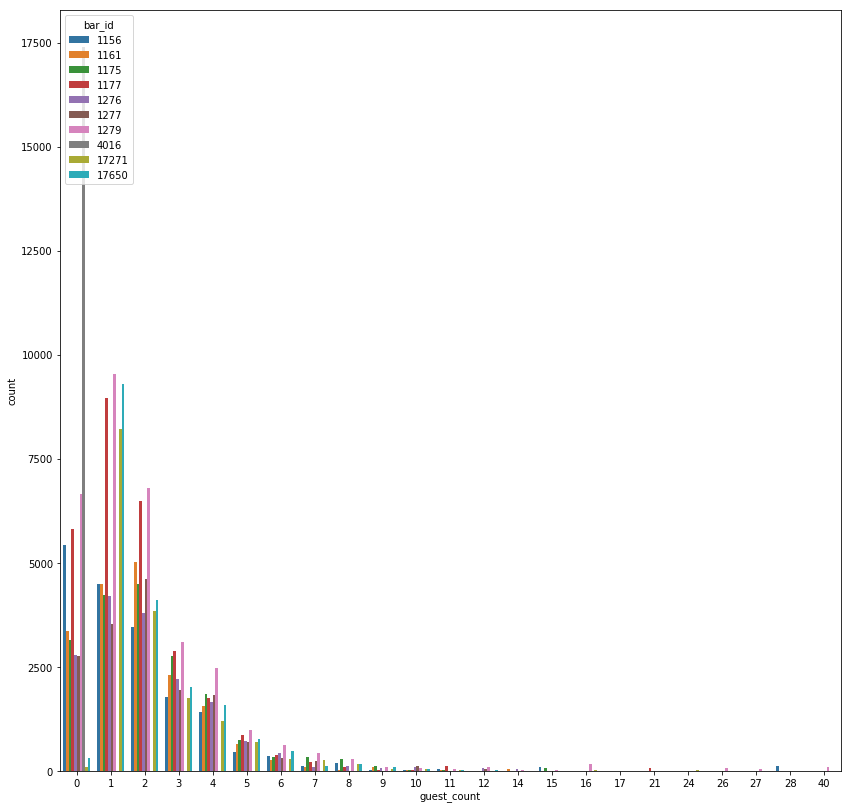

In [54]:
top10 = df[df['bar_id'].isin(top10_bars)]

plt.figure(figsize=(14, 14))
sns.countplot(x='guest_count', hue='bar_id', data=top10)